In [6]:
from qiskit import *
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt
import re
import csv

## Construction of the oracle $U_w$.

### Target state

In [7]:
Target_state = '100'

### Setting up the The Grover operator

In [8]:
# First we note the length of N.
N = len(Target_state)

# Then an identity matrix is created with the size 2**N.
Oracle = np.identity(2 ** N, dtype=complex)


# Then the sign of the element corresponding to the target state is flipped. To do that we first convert the
# target state from binary to decimal number. 
Target_index = int(Target_state, 2)

Oracle.itemset((Target_index, Target_index),-1)

## We will first create an operator with all elements 1. This is A = (1/N)|psi><psi|.
A = np.ones((2**N, 2**N))
Phase = (2/(2**N))*A - np.identity(2**N, dtype = complex)

## U is the Grover operator.
U = np.matmul(Phase, Oracle)


print('The Grover operator is',U)

The Grover operator is [[-0.75+0.j  0.25+0.j  0.25+0.j  0.25+0.j -0.25+0.j  0.25+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j -0.75+0.j  0.25+0.j  0.25+0.j -0.25+0.j  0.25+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j -0.75+0.j  0.25+0.j -0.25+0.j  0.25+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j -0.75+0.j -0.25+0.j  0.25+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j  0.75+0.j  0.25+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j -0.25+0.j -0.75+0.j  0.25+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j -0.25+0.j  0.25+0.j -0.75+0.j
   0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j -0.25+0.j  0.25+0.j  0.25+0.j
  -0.75+0.j]]


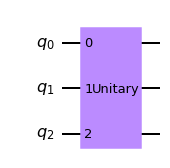

In [9]:
qc = QuantumCircuit(N)
qc.unitary(U,[i for i in range(N)])
qc.draw('mpl')

### We choose the basis gates as $Rz, CNOT$ and $H$

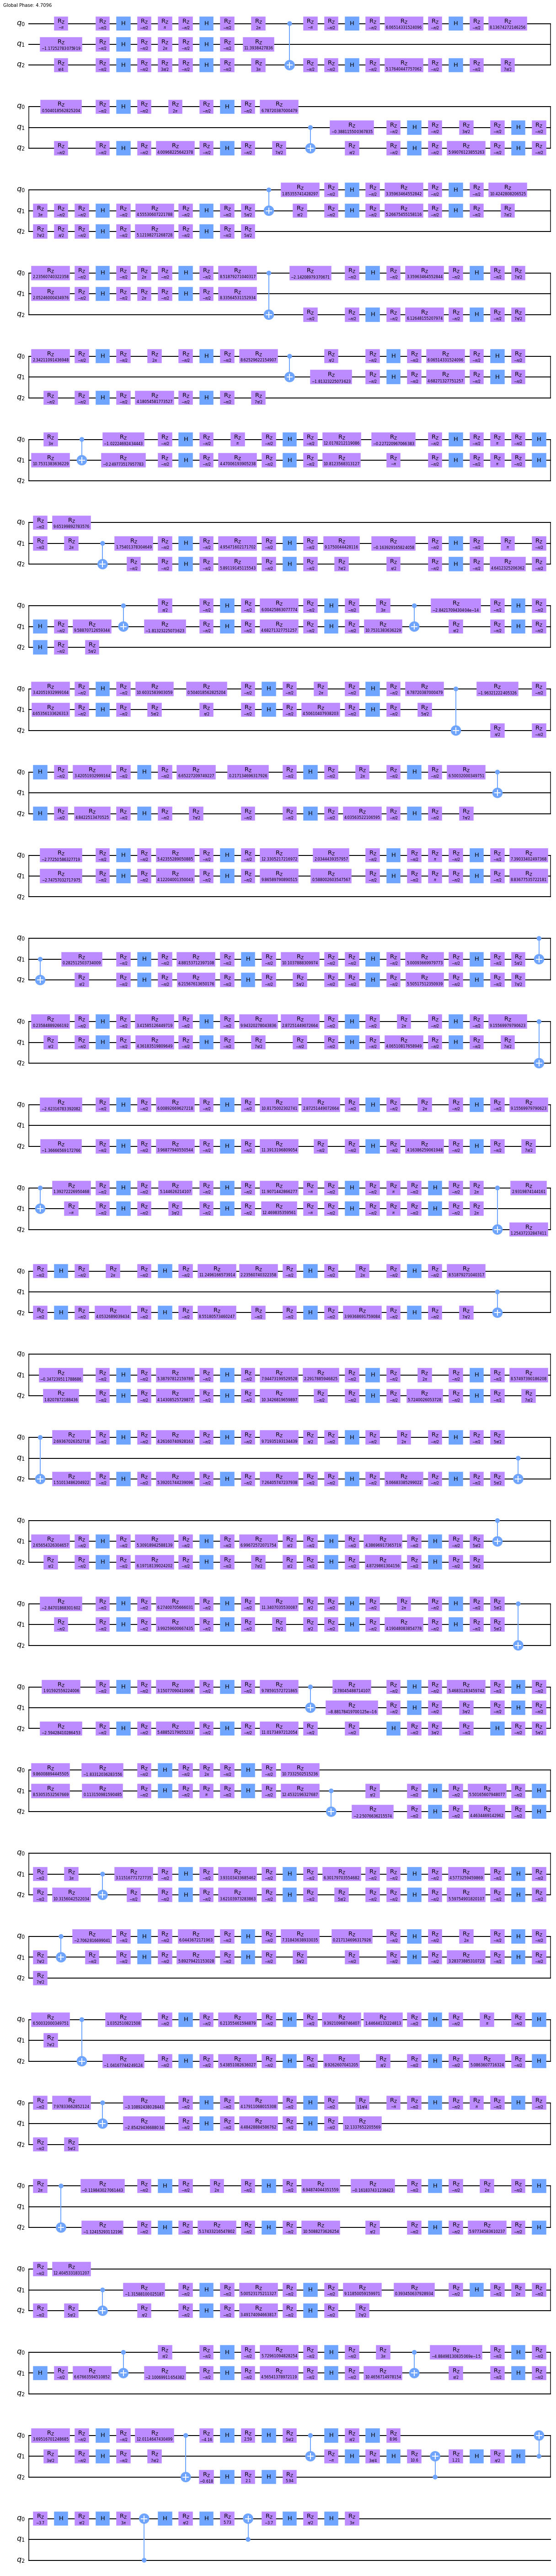

In [10]:
# The following line unfold the input matrix using 'transpile'. We will use rz,cx and h gate as our basis.
trans_qc = transpile(qc, basis_gates = ['id', 'rz', 'cx','h'], optimization_level = 3)
trans_qc.draw('mpl')

### Writing $1$ and $2$ qubit gates as human readable format

In [11]:
## (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.9817477042468101]),
#[Qubit(QuantumRegister(3, 'q'), 0)], [])

## (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0)], [])

## (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
#[Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 0)], [])

f = trans_qc
def List_Gates(Gate_Number):
    
    
    ## The list will hold string along with the angles in case of u3.
    l = []
    
    Name_of_Gate = []
    
    ## The list will hold the qubit in case of u3.
    Qubit = []    
    
    ## The list will hold the numerical value (float) of the angle in case of u3.
    Angle = []

    ## The following two lines will be used to separate the numerical value of the angle from 
    # a mixture of string and digits.
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ )?'
    
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'rz':
        
        Name_of_Gate.append('rz')        
        ## For the gate rz, there is one angle. The following lines puts the string which contain
        # the angle along with other alphabets in a list l.
        l.append(str(list(f)[Gate_Number]).split(',')[3])

        
        ## The following loop extracts the angle from the string of alphabet and digit.
        for i in l:
            
            if rx.findall(i) == []:
                
                ## the angle zero is written as 0.0 .
                Angle.append(0.0)
                
            else:
                
                Angle.append(float(rx.findall(i)[0]))
                
        ## the qubit on which rz acts is listed.        
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))  
        
    # For hadamard gates the qubit it is applied to is listed.    
    elif str(trans_qc[Gate_Number][0]).split(',')[0][-2:-1] == 'h':
        
        Name_of_Gate.append('h')
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))
    
    
        ## if the gate is cx then the Angle list is empty.        
    else:
        
        Name_of_Gate.append('cx')     
        ## the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][0]).split(',')[2])
        
        Target_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][1]).split(',')[2])   
        
        Qubit.append([Control_bit, Target_bit])
    
    
    return Name_of_Gate,Angle, Qubit

# The following list has all the gates in the format [name of the gate, angle, qubit].
l = []
for i in range(len(f)):
    l.append(List_Gates(i))   

# List of one and two qubit unitaries
The following loop creates a text file containing the one and two qubit unitary gates

In [21]:
file = open('gates_list.txt', 'w')

# The following variables will count number of each gates.
rz_count = 0
h_count = 0
cx_count = 0

for i in range(len(l)):
    
    if l[i][0][0] == 'rz':
        
        file.write('rz'+','+str(l[i][1][0])+','+str(l[i][2][0])+','+'\n')
        
        rz_count += 1
        
    elif l[i][0][0] == 'h':
        
        file.write('h'+','+'0.0'+','+str(l[i][2][0])+','+'\n')
        
        h_count += 1
        
    else:
        
        file.write('cx'+','+l[i][2][0][0]+','+l[i][2][0][1]+','+'\n')
        
        cx_count += 1

print(
    'Total gates used = ',len(l),'\n' \
      'Number of Rz gates =', rz_count,'\n'\
      'Number of Hadamard gates =', h_count,'\n'\
      'Number of CNOT gates =', cx_count
        )

Total gates used =  1100 
Number of Rz gates = 819 
Number of Hadamard gates = 244 
Number of CNOT gates = 37
